In [1]:
import pandas as pd

# 1. CSV 파일 읽기
file_path = 'pm10.csv'
df = pd.read_csv(file_path, encoding='cp949')

# 2. 지역명 합치기
df['지역'] = df['구분(1)'] + ' ' + df['구분(2)']
# 🔻 총계/소계 행 제거
df = df[~df['지역'].str.contains('총계|소계', na=False)]
df = df.drop(columns=['구분(1)', '구분(2)'])

# 3. * 제거 및 숫자 변환
for col in df.columns:
    if col != '지역':
        df[col] = df[col].astype(str).str.replace('*', '', regex=False)
        df[col] = pd.to_numeric(df[col], errors='coerce')

# 4. 데이터 구조 변경: wide → long
df_long = df.melt(id_vars='지역', var_name='월', value_name='PM10')

# 5. 월 컬럼에서 'MM'만 추출 (월별 평균을 위한 키)
df_long['월숫자'] = df_long['월'].str.extract(r'\.(\d+)$')

# 6. 결측치를 해당 지역의 같은 월 평균으로 채우기
df_long['PM10'] = df_long.groupby(['지역', '월숫자'])['PM10'].transform(lambda x: x.fillna(x.mean()))
df_long['PM10'] = df_long['PM10'].round(0).astype('Int64')
# 7. 다시 wide 포맷으로 되돌리기
df_cleaned = df_long.pivot(index='지역', columns='월', values='PM10').reset_index()

# 8. 열 순서 정렬 (연월 기준 정렬)
month_order = sorted([col for col in df_cleaned.columns if col != '지역'])
df_cleaned = df_cleaned[['지역'] + month_order]

# 9. 저장
output_path = 'pm10_cleaned.csv'
df_cleaned.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"✅ 완료: {output_path} 로 저장되었습니다.")


✅ 완료: pm10_cleaned.csv 로 저장되었습니다.


In [2]:
import pandas as pd

# 1. CSV 파일 읽기
file_path = 'pm25.csv'
df = pd.read_csv(file_path, encoding='cp949')

# 2. 지역명 합치기
df['지역'] = df['구분(1)'] + ' ' + df['구분(2)']
# 🔻 총계/소계 행 제거
df = df[~df['지역'].str.contains('총계|소계', na=False)]
df = df.drop(columns=['구분(1)', '구분(2)'])

# 3. * 제거 및 숫자 변환
for col in df.columns:
    if col != '지역':
        df[col] = df[col].astype(str).str.replace('*', '', regex=False)
        df[col] = pd.to_numeric(df[col], errors='coerce')

# 4. 데이터 구조 변경: wide → long
df_long = df.melt(id_vars='지역', var_name='월', value_name='PM25')

# 5. 월 컬럼에서 'MM' 추출
df_long['월숫자'] = df_long['월'].str.extract(r'\.(\d+)$')

# 6-1. 1차 보간: 해당 지역의 같은 월 평균
df_long['PM25'] = df_long.groupby(['지역', '월숫자'])['PM25'].transform(lambda x: x.fillna(x.mean()))

# 6-2. 2차 보간: 전체 지역의 해당 월 평균 (여전히 남은 결측치)
df_long['PM25'] = df_long.groupby('월')['PM25'].transform(lambda x: x.fillna(x.mean()))

# 7. 소수점 제거
df_long['PM25'] = df_long['PM25'].round(0).astype('Int64')

# 8. 다시 wide 포맷으로 되돌리기
df_cleaned = df_long.pivot(index='지역', columns='월', values='PM25').reset_index()

# 9. 열 순서 정렬
month_order = sorted([col for col in df_cleaned.columns if col != '지역'])
df_cleaned = df_cleaned[['지역'] + month_order]

# 10. 저장
output_path = 'pm25_cleaned.csv'
df_cleaned.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"✅ 완료: {output_path} 로 저장되었습니다.")


✅ 완료: pm25_cleaned.csv 로 저장되었습니다.


In [3]:
import pandas as pd

# 1. 파일 불러오기
pm10 = pd.read_csv("pm10_cleaned.csv", encoding='utf-8')
pm25 = pd.read_csv("pm25_cleaned.csv", encoding='utf-8')

# 2. 지역 이름 정리 (선택)
pm10['지역'] = pm10['지역'].str.replace(r'(시|군)$', '', regex=True)
pm25['지역'] = pm25['지역'].str.replace(r'(시|군)$', '', regex=True)

# 3. 컬럼 정리
pm10_cols = [col for col in pm10.columns if col != '지역']
pm25_cols = [col for col in pm25.columns if col != '지역']

# 4. 병합
merged = pd.merge(pm10, pm25, on='지역', suffixes=('_pm10', '_pm25'))

# 5. PM종합 계산: 각 월별 PM25×3 + PM10
combined = pd.DataFrame()
combined['지역'] = merged['지역']

for col in pm10_cols:
    pm10_col = f"{col}_pm10"
    pm25_col = f"{col}_pm25"
    if pm10_col in merged.columns and pm25_col in merged.columns:
        combined[col] = merged[pm10_col] + merged[pm25_col] * 3

# 6. 결과 저장
combined.to_csv("pm_combined_weighted.csv", index=False, encoding='utf-8-sig')


2. 인구 데이터 전처리

In [ ]:
import pandas as pd

# 파일 불러오기
population_path = "인구수_데이터.csv"
df_population = pd.read_csv(population_path, encoding='euc-kr')

# 열 이름 정리
df_population.columns = df_population.columns.str.strip()

# 필요한 열 추출
df_population = df_population[['행정구역', '2020년04월_총인구수']].copy()

# 괄호 제거 (행정코드 제거)
df_population['행정구역'] = df_population['행정구역'].str.replace(r'\s*\(.*\)', '', regex=True)

# 숫자형 변환
df_population['2020년04월_총인구수'] = df_population['2020년04월_총인구수'].str.replace(',', '').astype(int)

# 고유행정구역명 생성 함수
def normalize_region(name):
    parts = name.strip().split()
    if len(parts) >= 2:
        province, city = parts[0], parts[1]
        # 특별시, 광역시는 그대로 유지
        if '특별시' in province or '광역시' in province:
            return name.strip()
        # 일반 도는 '시' 또는 '군'으로 끝나면 제거
        if city.endswith('시') or city.endswith('군'):
            city = city[:-1]
        return f"{province} {city}"
    return name.strip()

# 적용
df_population['고유행정구역명'] = df_population['행정구역'].apply(normalize_region)

# 필요한 열 정리
population_ready = df_population[['고유행정구역명', '2020년04월_총인구수']]

# 저장
population_ready.to_csv("전처리된_인구수_데이터.csv", index=False, encoding='utf-8-sig')
print("✅ 인구 데이터 저장 완료 → '전처리된_인구수_데이터.csv'")


✅ 인구 데이터 저장 완료 → '전처리된_인구수_데이터.csv'


3-1. 병원 데이터 지역 합치기

In [59]:
import pandas as pd
import re

# 1. 파일 불러오기 (동일 디렉토리에 존재해야 함)
file_path = "./병원수_데이터.xlsx"
df_raw = pd.read_excel(file_path, sheet_name=0, header=None)

# 2. 헤더 설정
df_new = df_raw[3:].reset_index(drop=True)
df_new.columns = df_raw.iloc[2]

# 3. 통합할 도시 정의
city_patterns = {
    "경기도 수원시": r"^수원.*구$",
    "경기도 성남시": r"^성남.*구$",
    "경기도 안산시": r"^안산.*구$",
    "경기도 고양시": r"^고양.*구$",
    "경기도 용인시": r"^용인.*구$",
    "경기도 안양시": r"^안양.*구$",
    "충청북도 청주시": r"^청주.*구$",
    "충청남도 천안시": r"^천안.*구$",
    "경상북도 포항시": r"^포항.*구$",
    "경상남도 창원시": r"^창원.*구$",
    "전라북도 전주시": r"^전주.*구$"
}

# 4. 통합 로직
df_city_merge = df_new.copy()
merged_city_rows = []

for city_fullname, pattern in city_patterns.items():
    gu_rows = df_city_merge[df_city_merge['시군구'].str.contains(pattern, na=False)].copy()
    if gu_rows.empty:
        continue

    numeric_cols = gu_rows.select_dtypes(include='number').columns
    gu_sum = gu_rows[numeric_cols].sum()

    rep_row = gu_rows.iloc[0].copy()
    rep_row['시도'] = city_fullname
    rep_row['시군구'] = city_fullname.split()[-1]  # 시 이름만
    for col in numeric_cols:
        rep_row[col] = gu_sum[col]

    merged_city_rows.append(rep_row)
    df_city_merge = df_city_merge[~df_city_merge['시군구'].str.contains(pattern, na=False)]

# 5. 병합 및 저장
df_city_merged_final = pd.concat([df_city_merge, pd.DataFrame(merged_city_rows)], ignore_index=True)
df_city_merged_final.to_csv("./전국_주요도시_구통합_결과.csv", index=False, encoding="utf-8-sig")


3-2. 병원 데이터 전처리

In [61]:
import pandas as pd


# 1. 병원 데이터 파일 불러오기

hospital_file = "전국_주요도시_구통합_결과.csv"  # 동일 폴더에 있을 것
hospital_excel = pd.read_csv(hospital_file)


# 앞서 처리된 df_city_merged_final을 병원 수 전처리용으로 이어서 처리

# 1. 필요한 열 필터링 및 헤더 정리
df_hospital_cleaned = df_city_merged_final.copy()

# 2. 필요한 열만 추출
columns_needed = ['시도', '시군구', '상급종합병원', '종합병원', '병원', '의원', '보건소', '보건지소', '보건진료소']
df_hospital_cleaned = df_hospital_cleaned[columns_needed]

# 3. 숫자형 변환 (NaN 처리)
for col in columns_needed[2:]:
    df_hospital_cleaned[col] = pd.to_numeric(df_hospital_cleaned[col].replace('-', pd.NA), errors='coerce')

# 4. 고유행정구역명 생성
df_hospital_cleaned['고유행정구역명'] = df_hospital_cleaned['시도'].str.strip()

# 5. 총 의료기관 수 계산
df_hospital_cleaned['총의료기관수'] = df_hospital_cleaned[
    ['상급종합병원', '종합병원', '병원', '의원', '보건소', '보건지소', '보건진료소']
].sum(axis=1, skipna=True)

# 6. 최종 정리 및 저장
hospital_ready = df_hospital_cleaned[['고유행정구역명', '총의료기관수']]
final_output_path = "전처리된_병원수_데이터.csv"
hospital_ready.to_csv(final_output_path, index=False, encoding='utf-8-sig')

final_output_path

# (선택) 결과 미리보기
print(hospital_ready.head())

2 고유행정구역명   총의료기관수
0   서울특별시  10422.0
1   부산광역시   2856.0
2   대구광역시   2188.0
3   인천광역시   1973.0
4   광주광역시   1188.0


4. 면적 데이터 전처리

In [62]:
import pandas as pd
import re

# 1. 파일 경로 설정
input_path = "구통합_행정구역_현황.csv"

# 2. CSV 불러오기
df = pd.read_csv(input_path)

# 3. 지역 코드 제거 (괄호 안 제거)
df['소재지_정제'] = df['소재지(시군구)별(1)'].str.replace(r'\s*\(.*?\)', '', regex=True).str.strip()

# 4. 고유행정구역명 생성 함수
def normalize_area_name(name):
    parts = name.strip().split()
    if len(parts) >= 2:
        province, city = parts[0], parts[1]
        # 특별시/광역시는 그대로 유지
        if '특별시' in province or '광역시' in province:
            return name.strip()
        # 나머지는 시나 군으로 끝나면 마지막 글자 제거
        if city.endswith('시') or city.endswith('군'):
            city = city[:-1]
        return f"{province} {city}"
    return name.strip()

# 5. 고유행정구역명 생성
df['고유행정구역명'] = df['소재지_정제'].apply(normalize_area_name)

# 6. 면적 단위 변환
df['면적_km2'] = df['면적 (㎡)'] / 1_000_000

# 7. 필요한 컬럼 추출
df_area_cleaned = df[['고유행정구역명', '면적_km2']]

# 8. 최종 저장
output_path = "전처리된_면적_데이터.csv"
df_area_cleaned.to_csv(output_path, index=False, encoding='utf-8-sig')

print("✅ 저장 완료:", output_path)
print(df_area_cleaned.head())


✅ 저장 완료: 전처리된_면적_데이터.csv
   고유행정구역명       면적_km2
0    서울특별시   605.204048
1    부산광역시   771.309562
2    대구광역시  1499.473159
3    대전광역시   539.779480
4  세종특별자치시   464.962321


고령자 비율율

In [8]:
import pandas as pd


# 1. CSV 파일 불러오기

file_path = "고령인구비율_시도_시_군_구__20250523162509.csv"

# 인코딩 자동 감지: utf-8 → 실패하면 euc-kr
try:
    df_elderly = pd.read_csv(file_path, encoding="utf-8")
except UnicodeDecodeError:
    df_elderly = pd.read_csv(file_path, encoding="euc-kr")


# 2. 헤더 및 데이터 정리

# 첫 번째 행 제거 (설명 행)
df_elderly_cleaned = df_elderly.iloc[1:].copy()

# 열 이름 재설정
df_elderly_cleaned.columns = ['시도', '시군구', '고령인구비율(%)', '고령인구수', '전체인구수']


# 3. 고유행정구역명 생성 및 비율 변환

df_elderly_cleaned['고유행정구역명'] = df_elderly_cleaned['시도'].str.strip() + ' ' + df_elderly_cleaned['시군구'].str.strip()
df_elderly_cleaned['고령인구비율'] = pd.to_numeric(df_elderly_cleaned['고령인구비율(%)'], errors='coerce')


# 4. 불필요한 행 제거 및 지역명 정제

# '소계'가 포함된 행 제거
# '소계'가 포함된 행 중, 특별시/광역시/특별자치시/특별자치도 등 광역단위(시군구가 '소계')는 '고유행정구역명'에서 ' 소계'만 제거
mask = df_elderly_cleaned['시군구'] == '소계'
df_elderly_cleaned.loc[mask, '고유행정구역명'] = df_elderly_cleaned.loc[mask, '고유행정구역명'].str.replace(' 소계', '', regex=False)

# 특별자치도 명칭 통일
df_elderly_cleaned['고유행정구역명'] = df_elderly_cleaned['고유행정구역명'].str.replace("전북특별자치도", "전라북도")
df_elderly_cleaned['고유행정구역명'] = df_elderly_cleaned['고유행정구역명'].str.replace("강원특별자치도", "강원도")


# 5. 필요한 열만 선택 후 저장

df_elderly_final = df_elderly_cleaned[['고유행정구역명', '고령인구비율']]
df_elderly_final.to_csv("전처리된_고령인구비율.csv", index=False, encoding="utf-8-sig")
print("✅ 전처리 완료 → '전처리된_고령인구비율.csv' 저장됨")

# (선택) 확인용 출력
print(df_elderly_final.head())


✅ 전처리 완료 → '전처리된_고령인구비율.csv' 저장됨
  고유행정구역명  고령인구비율
1     NaN    15.6
2   서울특별시    15.3
3   부산광역시    18.3
4   대구광역시    15.7
5   인천광역시    13.1


In [9]:
import pandas as pd


# 1. 파일 불러오기

df_hospital = pd.read_csv("전처리된_병원수_데이터.csv", encoding='utf-8-sig')
df_population = pd.read_csv("전처리된_인구수_데이터.csv", encoding='utf-8-sig')
df_area = pd.read_csv("전처리된_면적_데이터.csv", encoding='utf-8-sig')

# 컬럼명 정리 (통일)
df_hospital.columns = ['고유행정구역명', '총의료기관수']
df_population.columns = ['고유행정구역명', '인구수']
df_area.columns = ['고유행정구역명', '면적_km2']


# 2. 병합

merged = pd.merge(df_hospital, df_population, on='고유행정구역명', how='inner')
merged = pd.merge(merged, df_area, on='고유행정구역명', how='inner')


# 3. 지표 계산

merged['인구10k명당_의료기관수'] = (merged['총의료기관수'] / merged['인구수']) * 10000
merged['면적1km2당_의료기관수'] = merged['총의료기관수'] / merged['면적_km2']


# 4. 정규화 (Min-Max)

merged['인구기준점수'] = (
    (merged['인구10k명당_의료기관수'] - merged['인구10k명당_의료기관수'].min()) /
    (merged['인구10k명당_의료기관수'].max() - merged['인구10k명당_의료기관수'].min())
)

merged['면적기준점수'] = (
    (merged['면적1km2당_의료기관수'] - merged['면적1km2당_의료기관수'].min()) /
    (merged['면적1km2당_의료기관수'].max() - merged['면적1km2당_의료기관수'].min())
)


# 5. 최종 의료접근 점수 (가중합)
#     면적지표 70%, 인구지표 30% 기준 적용

merged['의료접근_최종점수'] = (
    0.1 * merged['인구기준점수'] + 
    0.9 * merged['면적기준점수']
).round(3)


# 6. 의료취약지역 분류 (하위 30%)

threshold = merged['의료접근_최종점수'].quantile(0.4)
merged['의료취약지역여부'] = merged['의료접근_최종점수'] <= threshold


# 7. 결과 저장

merged.to_csv("의료접근점수_최종_결과.csv", index=False, encoding='utf-8-sig')
print("✅ '의료접근점수_최종_결과.csv' 저장 완료!")


# 8. 상위 결과 확인

print(merged[['고유행정구역명', '의료접근_최종점수', '의료취약지역여부']]
      .sort_values(by='의료접근_최종점수')
      .head(10))


✅ '의료접근점수_최종_결과.csv' 저장 완료!
      고유행정구역명  의료접근_최종점수  의료취약지역여부
154   경기도 용인시      0.014      True
156  충청북도 청주시      0.024      True
158  경상북도 포항시      0.027      True
157  충청남도 천안시      0.027      True
134   강원도 인제군      0.028      True
99   경상북도 울릉군      0.031      True
159  경상남도 창원시      0.031      True
125   강원도 삼척시      0.034      True
136   강원도 양양군      0.034      True
108  경상남도 함안군      0.035      True


In [13]:
import pandas as pd

# 1. 파일 불러오기
file_path = "WhoMergedPm.csv"
df = pd.read_csv(file_path)

# 2. 수치형 컬럼만 평균 계산 (지역별 평균농도)
# '지역'을 제외한 컬럼들의 평균을 행별로 계산하여 '평균농도' 컬럼으로 저장
df['평균농도'] = df.drop(columns=['지역']).mean(axis=1)

# 3. 고유행정구역명 생성: 괄호 제거 및 공백 정리
df['고유행정구역명'] = df['지역'].str.replace(r'\s*\(.*?\)', '', regex=True).str.strip()

# 4. 필요한 컬럼만 추출
df_cleaned = df[['고유행정구역명', '평균농도']]

# 5. 저장
output_path = "전처리된_평균농도_데이터.csv"
df_cleaned.to_csv(output_path, index=False, encoding='utf-8-sig')

print("✅ 저장 완료:", output_path)


✅ 저장 완료: 전처리된_평균농도_데이터.csv


In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1. 파일 불러오기
df_hospital = pd.read_csv("전처리된_병원수_데이터.csv", encoding='utf-8-sig')
df_population = pd.read_csv("전처리된_인구수_데이터.csv", encoding='utf-8-sig')
df_area = pd.read_csv("전처리된_면적_데이터.csv", encoding='utf-8-sig')
df_elderly = pd.read_csv("전처리된_고령인구비율.csv", encoding='utf-8-sig')

# 2. 컬럼명 통일
df_hospital.columns = ['고유행정구역명', '총의료기관수']
df_population.columns = ['고유행정구역명', '인구수']
df_area.columns = ['고유행정구역명', '면적_km2']
df_elderly.columns = ['고유행정구역명', '고령인구비율']

# 3. 병합
merged = pd.merge(df_hospital, df_population, on='고유행정구역명', how='inner')
merged = pd.merge(merged, df_area, on='고유행정구역명', how='inner')
merged = pd.merge(merged, df_elderly, on='고유행정구역명', how='left')

# 4. 지표 계산
merged['인구10k명당_의료기관수'] = (merged['총의료기관수'] / merged['인구수']) * 10000
merged['면적1km2당_의료기관수'] = merged['총의료기관수'] / merged['면적_km2']

# 5. 정규화 (Min-Max)
merged['인구기준점수'] = (
    (merged['인구10k명당_의료기관수'] - merged['인구10k명당_의료기관수'].min()) /
    (merged['인구10k명당_의료기관수'].max() - merged['인구10k명당_의료기관수'].min())
)

merged['면적기준점수'] = (
    (merged['면적1km2당_의료기관수'] - merged['면적1km2당_의료기관수'].min()) /
    (merged['면적1km2당_의료기관수'].max() - merged['면적1km2당_의료기관수'].min())
)

merged['고령기준점수'] = 1 - (
    (merged['고령인구비율'] - merged['고령인구비율'].min()) /
    (merged['고령인구비율'].max() - merged['고령인구비율'].min())
)

# 6. 실제 취약지역 레이블
vulnerable_regions = ["군위군", "강화군", "옹진군", "가평군", "동두천시", "양평군", "여주시", "연천군",
    "고성군", "동해시", "삼척시", "속초시", "양구군", "양양군", "영월군", "인제군", "정선군",
    "철원군", "태백시", "평창군", "홍천군", "화천군", "횡성군", "괴산군", "단양군", "보은군",
    "영동군", "옥천군", "음성군", "진천군", "충주시", "공주시", "금산군", "당진시", "보령시",
    "부여군", "서산시", "서천군", "예산군", "청양군", "태안군", "홍성군", "고창군", "남원시",
    "무주군", "부안군", "순창군", "임실군", "장수군", "정읍시", "진안군", "강진군", "고흥군",
    "곡성군", "구례군", "나주시", "담양군", "무안군", "보성군", "신안군", "영광군", "영암군",
    "완도군", "장성군", "장흥군", "진도군", "함평군", "해남군", "고령군", "문경시", "봉화군",
    "상주시", "성주군", "영덕군", "영주시", "영양군", "영천시", "예천군", "울릉군", "울진군",
    "의성군", "청도군", "청송군", "거제시", "거창군", "고성군", "남해군", "밀양시", "사천시",
    "산청군", "의령군", "창녕군", "통영시", "하동군", "함안군", "함양군", "합천군", "서귀포시"]  # ← 리스트는 그대로 유지
merged['실제취약지역'] = merged['고유행정구역명'].apply(lambda x: int(any(v in x for v in vulnerable_regions)))

# 7. 로지스틱 회귀로 가중치 학습
X = merged[['인구기준점수', '면적기준점수', '고령기준점수']]
X_clean = X.dropna()
y_clean = merged.loc[X_clean.index, '실제취약지역']

X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, stratify=y_clean, test_size=0.2, random_state=123)

model = LogisticRegression()
model.fit(X_train, y_train)

w1, w2, w3 = model.coef_[0]
print(f"학습된 가중치 → 인구: {w1:.3f}, 면적: {w2:.3f}, 고령: {w3:.3f}")

# 8. 정규화 후 점수 계산
total = abs(w1) + abs(w2) + abs(w3)
merged['의료접근_최종점수'] = (
    abs(w1) / total * merged['인구기준점수'] +
    abs(w2) / total * merged['면적기준점수'] +
    abs(w3) / total * merged['고령기준점수']
).round(3)

# 9. 의료취약지역 분류 (하위 60.8%)
threshold = merged['의료접근_최종점수'].quantile(0.608)
merged['예측취약지역'] = merged['의료접근_최종점수'] <= threshold

# 10. 평가 지표 출력
y_true = y_clean
y_pred = merged.loc[X_clean.index, '예측취약지역']

print("\n정확도:", accuracy_score(y_true, y_pred))
print("\n분류 보고서:\n", classification_report(y_true, y_pred))
print("\n 혼동 행렬:\n", confusion_matrix(y_true, y_pred))

# 11. 저장
merged.to_csv("의료접근점수_최종_결과_로지스틱기반.csv", index=False, encoding='utf-8-sig')
print("\n✅ 저장 완료: '의료접근점수_최종_결과_로지스틱기반.csv'")


학습된 가중치 → 인구: 1.087, 면적: -1.059, 고령: -4.087

정확도: 0.8819875776397516

분류 보고서:
               precision    recall  f1-score   support

           0       0.87      0.83      0.85        66
           1       0.89      0.92      0.90        95

    accuracy                           0.88       161
   macro avg       0.88      0.87      0.88       161
weighted avg       0.88      0.88      0.88       161


 혼동 행렬:
 [[55 11]
 [ 8 87]]

✅ 저장 완료: '의료접근점수_최종_결과_로지스틱기반.csv'


In [11]:
import pandas as pd
import re

# 1. 파일 불러오기
file_path = "hazard_facility.csv"
df_raw = pd.read_csv(file_path, encoding='utf-8')

# 2. 공백 제거
df_raw.columns = df_raw.columns.str.strip()
df_raw['시도명'] = df_raw['시도명'].str.strip()
df_raw['시군구'] = df_raw['시군구'].str.strip()

# 3. 광역시 목록
metropolitan_cities = [
    "서울특별시", "부산광역시", "대구광역시", "인천광역시",
    "광주광역시", "대전광역시", "울산광역시", "세종특별자치시"
]

# 4. 숫자형 열 추출
numeric_cols = df_raw.select_dtypes(include='number').columns.tolist()

# 5. 광역시는 시도 기준으로 병합
wide_df = df_raw[df_raw['시도명'].isin(metropolitan_cities)]
wide_df_grouped = wide_df.groupby('시도명')[numeric_cols].sum().reset_index()
wide_df_grouped['고유행정구역명'] = wide_df_grouped['시도명']

# 6. 나머지 시군구 데이터 추출
df_non_wide = df_raw[~df_raw['시도명'].isin(metropolitan_cities)]

# 7. 주요 구단위 도시 병합
city_patterns = {
    "경기도 수원시": r"^수원.*구$",
    "경기도 성남시": r"^성남.*구$",
    "경기도 안산시": r"^안산.*구$",
    "경기도 고양시": r"^고양.*구$",
    "경기도 용인시": r"^용인.*구$",
    "경기도 안양시": r"^안양.*구$",
    "경기도 부천시": r"^부천.*구$",
    "충청북도 청주시": r"^청주.*구$",
    "충청남도 천안시": r"^천안.*구$",
    "경상북도 포항시": r"^포항.*구$",
    "경상남도 창원시": r"^창원.*구$",
    "전라북도 전주시": r"^전주.*대대구$"
}

df_city_merge = df_non_wide.copy()
merged_city_rows = []

for city_fullname, pattern in city_patterns.items():
    gu_rows = df_city_merge[df_city_merge['시군구'].str.contains(pattern, na=False)].copy()
    if gu_rows.empty:
        continue

    gu_sum = gu_rows[numeric_cols].sum()
    rep_row = gu_rows.iloc[0].copy()
    rep_row['시도명'] = city_fullname.split()[0]
    rep_row['시군구'] = city_fullname.split()[1]
    for col in numeric_cols:
        rep_row[col] = gu_sum[col]
    merged_city_rows.append(rep_row)

    df_city_merge = df_city_merge[~df_city_merge['시군구'].str.contains(pattern, na=False)]

# 8. 병합 후 고유행정구역명 생성
df_merged_city = pd.concat([df_city_merge, pd.DataFrame(merged_city_rows)], ignore_index=True)
df_merged_city['고유행정구역명'] = df_merged_city['시도명'] + ' ' + df_merged_city['시군구']

# 광역시는 유지, 그 외는 '시', '군' 제거
def clean_region(name):
    if any(city in name for city in ["특별시", "광역시", "특별자치시"]):
        return name  # 그대로 유지
    return re.sub(r'(시|군)$', '', name)

df_merged_city['고유행정구역명'] = df_merged_city['고유행정구역명'].apply(clean_region)

# 광역시 병합된 부분도 동일하게 처리
wide_df_grouped['고유행정구역명'] = wide_df_grouped['고유행정구역명'].apply(clean_region)


# 9. wide 광역시 병합된 결과와 최종 합치기
df_final = pd.concat([
    df_merged_city[['고유행정구역명'] + numeric_cols],
    wide_df_grouped[['고유행정구역명'] + numeric_cols]
], ignore_index=True)

# 10. 저장
output_path = "hazard_facility_고유.csv"
df_final.to_csv(output_path, index=False, encoding="utf-8-sig")

print(f"✅ 고유행정구역 기준 통합 완료 → {output_path}")


✅ 고유행정구역 기준 통합 완료 → hazard_facility_고유.csv


In [22]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1. 파일 불러오기
df_hospital = pd.read_csv("전처리된_병원수_데이터.csv", encoding='utf-8-sig')
df_population = pd.read_csv("전처리된_인구수_데이터.csv", encoding='utf-8-sig')
df_area = pd.read_csv("전처리된_면적_데이터.csv", encoding='utf-8-sig')
df_elderly = pd.read_csv("전처리된_고령인구비율.csv", encoding='utf-8-sig')
df_pm = pd.read_csv("전처리된_평균농도_데이터.csv", encoding='utf-8-sig')

# 2. 고유행정구역명 정규화 함수 정의
def normalize_region_name(name):
    name = str(name).strip()
    name = name.replace('시', '').replace('군', '')
    return name.strip()

# 3. 고유행정구역명 통일 적용
for df in [df_hospital, df_population, df_area, df_elderly, df_pm]:
    df['고유행정구역명'] = df['고유행정구역명'].apply(normalize_region_name)

# 4. 컬럼명 정리
df_hospital.columns = ['고유행정구역명', '총의료기관수']
df_population.columns = ['고유행정구역명', '인구수']
df_area.columns = ['고유행정구역명', '면적_km2']
df_elderly.columns = ['고유행정구역명', '고령인구비율']
df_pm.columns = ['고유행정구역명', '평균농도']

# 5. 병합
merged = pd.merge(df_hospital, df_population, on='고유행정구역명', how='inner')
merged = pd.merge(merged, df_area, on='고유행정구역명', how='inner')
merged = pd.merge(merged, df_elderly, on='고유행정구역명', how='left')
merged = pd.merge(merged, df_pm, on='고유행정구역명', how='left')

# 6. 평균농도 결측치 처리
merged['평균농도'] = merged['평균농도'].fillna(merged['평균농도'].mean())

# 7. 미세먼지기준점수 정규화
merged['미세먼지기준점수'] = (
    (merged['평균농도'].max() - merged['평균농도']) /
    (merged['평균농도'].max() - merged['평균농도'].min())
)

# 확인용 출력
print("\n📌 병합 완료 및 미세먼지기준점수 추가:")
print(merged[['고유행정구역명', '평균농도', '미세먼지기준점수']].head())

# 병합된 파일 저장
merged.to_csv("병합_정규화_완료.csv", index=False, encoding='utf-8-sig')
print("\n✅ 저장 완료: '병합_정규화_완료.csv'")



📌 병합 완료 및 미세먼지기준점수 추가:
  고유행정구역명        평균농도  미세먼지기준점수
0    서울특별  113.458333  0.355071
1    부산광역  109.916667  0.398833
2    대구광역  109.291667  0.406556
3    인천광역  115.763889  0.326583
4    광주광역  108.666667  0.414278

✅ 저장 완료: '병합_정규화_완료.csv'


In [27]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# 데이터 불러오기
hospital = pd.read_csv("전처리된_병원수_데이터.csv")
population = pd.read_csv("전처리된_인구수_데이터.csv")
area = pd.read_csv("전처리된_면적_데이터.csv")
elderly = pd.read_csv("전처리된_고령인구비율.csv")
pm = pd.read_csv("전처리된_평균농도_데이터.csv")

# 컬럼명 통일
hospital.columns = ['고유행정구역명', '총의료기관수']
population.columns = ['고유행정구역명', '인구수']
area.columns = ['고유행정구역명', '면적_km2']
elderly.columns = ['고유행정구역명', '고령인구비율']
pm.columns = ['고유행정구역명', '평균농도']

# 전처리 함수: '시', '군' 제거
def normalize_region_name(name):
    name = str(name).strip()
    name = name.replace('시', '').replace('군', '')
    return name.strip()

for df in [hospital, population, area, elderly, pm]:
    df['고유행정구역명'] = df['고유행정구역명'].apply(normalize_region_name)

# 병합
df = hospital.merge(population, on='고유행정구역명') \
             .merge(area, on='고유행정구역명') \
             .merge(elderly, on='고유행정구역명') \
             .merge(pm, on='고유행정구역명')

# 지표 계산
df['인구10k명당_의료기관수'] = df['총의료기관수'] / df['인구수'] * 10000
df['면적1km2당_의료기관수'] = df['총의료기관수'] / df['면적_km2']

# 정규화
scaler = MinMaxScaler()
df[['인구기준점수', '면적기준점수', '고령기준점수', '미세먼지기준점수']] = scaler.fit_transform(
    pd.DataFrame({
        '인구기준점수': df['인구10k명당_의료기관수'],
        '면적기준점수': df['면적1km2당_의료기관수'],
        '고령기준점수': 1 - df['고령인구비율'],
        '미세먼지기준점수': df['평균농도'].max() - df['평균농도']
    })
)

# 클러스터링
X_features = df[['인구기준점수', '면적기준점수', '고령기준점수', '미세먼지기준점수']]
kmeans = KMeans(n_clusters=2, random_state=123)
df['클러스터'] = kmeans.fit_predict(X_features)

# 분류기 학습
X = X_features
y = df['클러스터']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=123, test_size=0.2)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 결과 저장
df.to_csv("클러스터링_기반_의료취약분석결과.csv", index=False, encoding='utf-8-sig')

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 변수 중요도
weights = model.coef_[0]
importance = pd.DataFrame({
    '변수': X.columns,
    '가중치': weights,
    '절댓값': np.abs(weights)
}).sort_values('절댓값', ascending=False)




importance, accuracy_score(y_test, y_pred), classification_report(y_test, y_pred, output_dict=True), confusion_matrix(y_test, y_pred)


(         변수       가중치       절댓값
 2    고령기준점수  3.556237  3.556237
 0    인구기준점수 -2.321125  2.321125
 3  미세먼지기준점수 -1.789973  1.789973
 1    면적기준점수  0.548714  0.548714,
 1.0,
 {'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 11.0},
  '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 15.0},
  'accuracy': 1.0,
  'macro avg': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 26.0},
  'weighted avg': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 26.0}},
 array([[11,  0],
        [ 0, 15]]))


📌 변수 중요도 (절댓값 기준):
         변수       가중치       절댓값
3  미세먼지기준점수  2.415950  2.415950
2    고령기준점수 -2.181335  2.181335
0    인구기준점수  1.428550  1.428550
1    면적기준점수 -0.165986  0.165986

📋 분류 리포트:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.92      1.00      0.96        12
           2       1.00      0.88      0.93         8

    accuracy                           0.96        26
   macro avg       0.97      0.96      0.96        26
weighted avg       0.96      0.96      0.96        26


✅ 정확도: 0.9615384615384616

🧮 혼동 행렬:
[[ 6  0  0]
 [ 0 12  0]
 [ 0  1  7]]


C:\Users\080a3\AppData\Local\Temp\ipykernel_37620\265919584.py:117: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\080a3\AppData\Local\Temp\ipykernel_37620\265919584.py:117: UserWarning: Glyph 47308 (\N{HANGUL SYLLABLE RYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\080a3\AppData\Local\Temp\ipykernel_37620\265919584.py:117: UserWarning: Glyph 52712 (\N{HANGUL SYLLABLE CWI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\080a3\AppData\Local\Temp\ipykernel_37620\265919584.py:117: UserWarning: Glyph 50557 (\N{HANGUL SYLLABLE YAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\080a3\AppData\Local\Temp\ipykernel_37620\265919584.py:117: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\080a3\AppData\Local\Temp\ipykernel_37620\265919584.py:117: UserWarning: Glyph 47084 (\N{HANGUL SYLLABLE REO}) missing fro

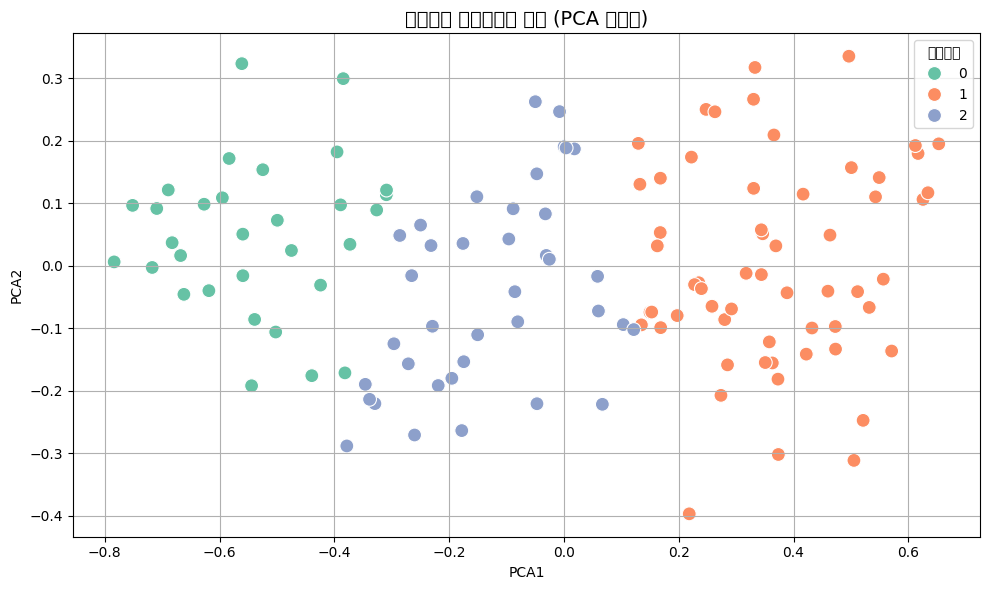


💾 저장 완료: '클러스터링_기반_의료취약분석결과.csv'


In [30]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# 1. 데이터 불러오기
# -----------------------------
hospital = pd.read_csv("전처리된_병원수_데이터.csv")
population = pd.read_csv("전처리된_인구수_데이터.csv")
area = pd.read_csv("전처리된_면적_데이터.csv")
elderly = pd.read_csv("전처리된_고령인구비율.csv")
pm = pd.read_csv("전처리된_평균농도_데이터.csv")

# -----------------------------
# 2. 컬럼명 통일 및 지역명 정제
# -----------------------------
hospital.columns = ['고유행정구역명', '총의료기관수']
population.columns = ['고유행정구역명', '인구수']
area.columns = ['고유행정구역명', '면적_km2']
elderly.columns = ['고유행정구역명', '고령인구비율']
pm.columns = ['고유행정구역명', '평균농도']

def normalize_region_name(name):
    name = str(name).strip()
    name = name.replace('시', '').replace('군', '')
    return name.strip()

for df in [hospital, population, area, elderly, pm]:
    df['고유행정구역명'] = df['고유행정구역명'].apply(normalize_region_name)

# -----------------------------
# 3. 병합 및 지표 계산
# -----------------------------
df = hospital.merge(population, on='고유행정구역명') \
             .merge(area, on='고유행정구역명') \
             .merge(elderly, on='고유행정구역명') \
             .merge(pm, on='고유행정구역명')

df['인구10k명당_의료기관수'] = df['총의료기관수'] / df['인구수'] * 10000
df['면적1km2당_의료기관수'] = df['총의료기관수'] / df['면적_km2']

# -----------------------------
# 4. 정규화
# -----------------------------
scaler = MinMaxScaler()
df[['인구기준점수', '면적기준점수', '고령기준점수', '미세먼지기준점수']] = scaler.fit_transform(
    pd.DataFrame({
        '인구기준점수': df['인구10k명당_의료기관수'],
        '면적기준점수': df['면적1km2당_의료기관수'],
        '고령기준점수': 1 - df['고령인구비율'],  # 고령 비율 높을수록 취약하므로 반대로
        '미세먼지기준점수': df['평균농도'].max() - df['평균농도']  # 높은 미세먼지 = 더 나쁨
    })
)

# -----------------------------
# 5. 클러스터링 (3개 클러스터)
# -----------------------------
X_features = df[['인구기준점수', '면적기준점수', '고령기준점수', '미세먼지기준점수']]
kmeans = KMeans(n_clusters=3, random_state=123)
df['클러스터'] = kmeans.fit_predict(X_features)

# -----------------------------
# 6. 로지스틱 회귀 분류기 학습
# -----------------------------
X = X_features
y = df['클러스터']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=123, test_size=0.2)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# -----------------------------
# 7. 변수 중요도 출력
# -----------------------------
weights = model.coef_[0]
importance = pd.DataFrame({
    '변수': X.columns,
    '가중치': weights,
    '절댓값': np.abs(weights)
}).sort_values('절댓값', ascending=False)

print("\n📌 변수 중요도 (절댓값 기준):")
print(importance)

# -----------------------------
# 8. 평가 결과 출력
# -----------------------------
print("\n📋 분류 리포트:")
print(classification_report(y_test, y_pred))
print("\n✅ 정확도:", accuracy_score(y_test, y_pred))
print("\n🧮 혼동 행렬:")
print(confusion_matrix(y_test, y_pred))

# -----------------------------
# 9. PCA 시각화
# -----------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_features)
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='클러스터', palette='Set2', s=100)
plt.title("의료취약 클러스터링 결과 (PCA 시각화)", fontsize=14)
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend(title='클러스터')
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# 10. 결과 저장
# -----------------------------
df.to_csv("클러스터링_기반_의료취약분석결과.csv", index=False, encoding='utf-8-sig')
print("\n💾 저장 완료: '클러스터링_기반_의료취약분석결과.csv'")
